# Analysing the final propositions generated from VisDial dataset and used in the experiments

In [1]:
import copy
import itertools
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import random

from collections import Counter

%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
PATH_VISDIAL = 'data/visual_dialog/'
DIR = 'propositions/'

SPLITS = ('train', 'val', 'test')

Select either original to analyse all or downsampled/balanced to analyse the final versions used in the paper.

In [3]:
which_probes = {'train': 'downsampled-balanced-', 'val': 'downsampled-', 'test': 'downsampled-'}

Load datasets:

In [4]:
datasets = {}
visdial = {}
propositions = {}

for split in SPLITS:
    with open(f'{PATH_VISDIAL}visdial_1.0_{split}.json', 'r') as data:
        visdial[split] = json.load(data)
        datasets[split] = visdial[split]['data']['dialogs']

for split in SPLITS:
    with open(f'{DIR}{which_probes[split]}propositions_{split}.json', 'r') as data:
        props = json.load(data)
        propositions[split] = props['dialogues']

Checking how many of the original dialogues ended up in the samples:

In [5]:
print('Train: ', len([k for k,v in propositions['train'].items() if v]))
print('Val: ', len([k for k,v in propositions['val'].items() if v]))
print('Test: ', len([k for k,v in propositions['test'].items() if v]))

Train:  95369
Val:  1979
Test:  6880


We'll remove the empty, unused dialogues from the analysis:

In [6]:
propositions['train'] = {k:v for k,v in propositions['train'].items() if v !={}}
propositions['val'] = {k:v for k,v in propositions['val'].items() if v !={}}
propositions['test'] = {k:v for k,v in propositions['test'].items() if v !={}}

### Examining an example of generated probes for a dialogue:

In [7]:
def get_vd_dialogue(vd_dialog, split, add_punct=False):
    
    caption = vd_dialog['caption']
    if add_punct:
        caption += '.'
    
    turns = []
    for qa in vd_dialog['dialog']:
        q = visdial[split]['data']['questions'][qa['question']]
        if add_punct:
            q += '?'
        try:
            a = visdial[split]['data']['answers'][qa['answer']] 
            if add_punct:
                a += '.'
        except KeyError:
            a = ''
        turns.append((q, a))
        
    return caption, turns

Pick a random dialogue:

In [8]:
split = 'val'
ID = random.randint(0, len(datasets[split])) # 46907
print(ID)
print(visdial[split]['data']['dialogs'][ID]['image_id'])

827
439367


In [9]:
caption, turns = get_vd_dialogue(datasets[split][ID], split, add_punct=True)
dialogue = [('', caption)] + turns

probes = [[] for n in range(11)]
for p in propositions[split][str(ID)].values():
    turn = int(p['turn_shared'])
    probes[turn].append(p['proposition'])

for n in range(11):
    print(f'{n} {dialogue[n][0]} {dialogue[n][1]}')
    if probes[n]:
        for i in range(0, len(probes[n]), 2):
            print(f'\t{probes[n][i]}\n\t{probes[n][i+1]}')
    else:
        print('    --')

0  4 small white bowls of associated foods on a table.
	one can see white bowls.
	one cannot see white bowls.
	there is a table.
	there is no table.
1 are the bowls the same size? no.
	the bowls are not the same size.
	the bowls are the same size.
2 can you see the table? yes.
	one can see a table.
	one cannot see any table.
3 does it have a tablecloth? i can't tell if this is a cloth or just the color of the table.
    --
4 what color is it? white.
	the tablecloth is white.
	the tablecloth is not white.
5 are there any flowers? no.
	there are no flowers.
	there are flowers.
6 is the food fresh? some of it appears to be.
    --
7 is there fruit in the bowls? yes in 1 bowl.
	there is fruit in the bowls.
	there is no fruit in the bowls.
8 can you see any cups? no.
	one cannot see any cups.
	one can see cups.
9 do the bowls have patterns on it? no.
	the bowls do not have patterns on it.
	the bowls have patterns on it.
10 is there soup on a bowl? no.
	there is no soup on a bowl.
	there is 

# Analysis of the resulting propositions

## Manipulated turns per dialogue

How many turns in a dialogue have been turned into propositions?

In [10]:
manipulated_turns = {}
mean_manip_turns = {}
df_manip_turns = {}

keys = list(range(1, 12))
for split in SPLITS:
    manipulated_turns[split] = Counter([len(set([p['turn_shared'] for p in dialogue.values()])) 
                                                                  for dialogue in propositions[split].values()])
    
    mean_manip_turns[split] = sum([turns*freq for turns, freq in manipulated_turns[split].items()]) / sum(manipulated_turns[split].values())
    
    df_manip_turns[split] = pd.DataFrame([manipulated_turns[split][i] for i in keys], index=keys, columns=['frequency']).transpose()
    print(f'On average, the {split} set has {mean_manip_turns[split]} manipulated turns per dialogue.')

On average, the train set has 2.2813492854072077 manipulated turns per dialogue.
On average, the val set has 5.726124305204649 manipulated turns per dialogue.
On average, the test set has 3.1379360465116277 manipulated turns per dialogue.


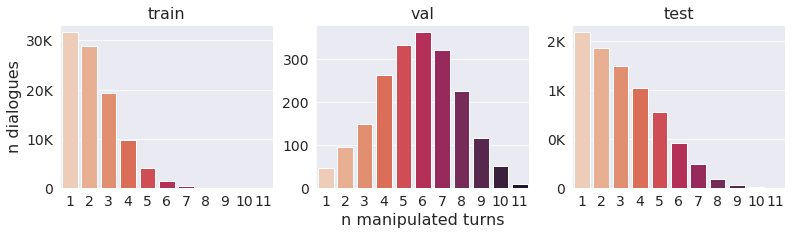

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(13,3))
#fig.suptitle('How many turns in a dialogue were turned into propositions')

for i, (ax, split) in enumerate(zip(axes, SPLITS)):
    sns.barplot(data=df_manip_turns[split], ax=ax, palette='rocket_r') 
    ax.set_title(split, fontsize=16)
    ax.tick_params(labelsize=14)
    if i != 1:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K' if x != 0 else 0))
    if i == 0:
        ax.set_ylabel('n dialogues', fontsize=16)
    if i == 1:
        ax.set_xlabel('n manipulated turns', fontsize=16)
split = 'train'
plt.savefig(f'plots/howmany-turns-{which_probes[split]}{split}.pdf',  bbox_inches="tight") 
plt.show()

The test set has a different distribution because it has incomplete dialogues. The balanced train set has a different distribution because of the sampling.

## At which turn propositions shift from private to shared

In [12]:
shift_turn = {}
df_shift_turn = {}
keys = list(range(11))
for split in SPLITS:
    shift_turn[split]= Counter([p['turn_shared'] for dialogue in propositions[split].values() 
                                                 for p in dialogue.values()])
    df_shift_turn[split] = pd.DataFrame([shift_turn[split][i] for i in keys], index=keys, columns=['frequency']).transpose()

The point where private/shared is balanced is between turn 5-6 on the balanced training set and at turn 3 on the original set (due to the many caption propositions).

In [13]:
split = 'train'
total = sum([value for key, value in shift_turn[split].items()])
print(total)

cum = 0
for i in range(11):
    cum += shift_turn[split][i]
    print(i,  cum / total)

344988
0 0.04891764351223811
1 0.10714575579440444
2 0.17433649866082299
3 0.2541247811518082
4 0.34535404129998726
5 0.4451198302549654
6 0.5513235242964972
7 0.6623041960879799
8 0.7760965598803437
9 0.8920136352568785
10 1.0


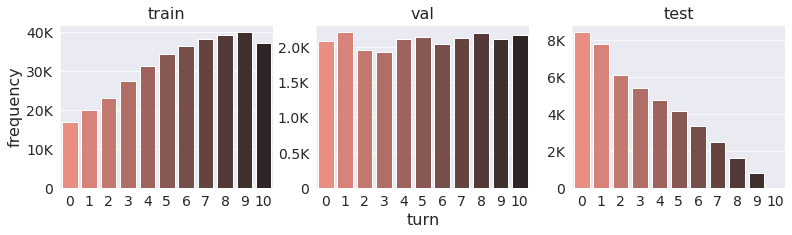

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(13,3))

#fig.suptitle('Which QA pair was manipulated?')

for i, (ax, split) in enumerate(zip(axes, SPLITS)):

    sns.barplot(data=df_shift_turn[split], ax=ax, palette='dark:salmon_r') 
    ax.set_title(split, fontsize=16)
    ax.tick_params(labelsize=14)

    if i == 0:
        ax.set_ylabel('frequency', fontsize=16)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K' if x != 0 else 0))
    if i == 1:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000) + 'K' if x != 0 else 0))
        ax.set_xlabel('turn', fontsize=16)
    if i == 2:
        
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K' if x != 0 else 0))

split = 'train'
plt.savefig(f'plots/which-turn-{which_probes[split]}{split}.pdf',  bbox_inches="tight") 
#plt.savefig('propositions/original-propositions_turn-distribution.png',  bbox_inches="tight")  
plt.show()

Constructing the balanced train set causes the distribution so be slightly skewed towards later turns... this will induce some bias on the private dimension, but mid point is still between turn 5 and 6.

## Propositions per dialogue

How many propositions were generated for each dialogue?

In [15]:
n_propositions = {}
mean_n_props = {}
df_n_props = {}
N_MAX = 50
keys = list(range(N_MAX))

for split in SPLITS:
    n_propositions[split] = Counter([len(dialogue.values()) for dialogue in propositions[split].values()])
    df_n_props[split] = pd.DataFrame([n_propositions[split][i] for i in keys], index=keys, columns=['frequency']).transpose()

    mean_n_props[split] = sum([turns*freq for turns, freq in n_propositions[split].items()]) / len(propositions[split])
    
    print(f'On average, the {split} set has {mean_n_props[split]} propositions per dialogue.')
    min_p = min(n_propositions[split].keys())
    max_p = max(n_propositions[split].keys())
    print(f'The {split} set has dialogues with minimum {min_p} and maximum {max_p} propositions. \n')

On average, the train set has 3.617401881114408 propositions per dialogue.
The train set has dialogues with minimum 1 and maximum 16 propositions. 

On average, the val set has 11.652349671551288 propositions per dialogue.
The val set has dialogues with minimum 2 and maximum 26 propositions. 

On average, the test set has 6.534011627906977 propositions per dialogue.
The test set has dialogues with minimum 2 and maximum 22 propositions. 



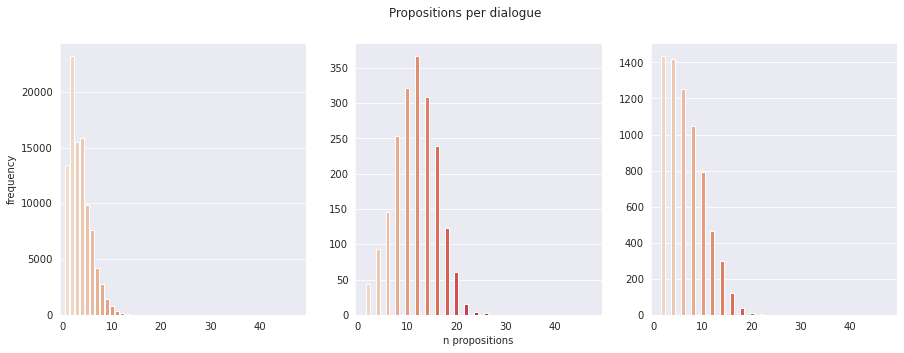

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

fig.suptitle('Propositions per dialogue')

for i, (ax, split) in enumerate(zip(axes, SPLITS)):

    g = sns.barplot(data=df_n_props[split], ax=ax, palette='rocket_r') 
    g.set_xticks([0, 10, 20, 30, 40])
    g.set_xticklabels(['0', '10', '20', '30', '40'])
    
    if i == 0:
        ax.set(ylabel='frequency')
    if i == 1:
        ax.set(xlabel='n propositions')
        
plt.show()

n_propositions is always an even number by construction. The balanced train set differs because of the sampling that does not guarantee the occurrence of both entailment+contradiction cases for all probes (which is good to reduce bias).

## Polarity of original answers

- Positive: propositions deriving from questions whose answers in the dialogue were yes. 
- Negative: propositions deriving from questions whose answers in the dialogue were no.
- Nan: propositions deriving from captions or questions that were not polar questions (e.g. what color is the dog? black); can be also considered positive facts about the image.

In [17]:
prop_polarity = {}

for split in SPLITS:
    prop_polarity[split] = Counter([p['qa_fact'] for dialogue in propositions[split].values() 
                                         for p in dialogue.values()])

polarities = prop_polarity['train'].keys()

d_polar = {split: [prop_polarity[split][p]*100 / sum(prop_polarity[split].values()) for p in polarities] for split in SPLITS}

In [18]:
df_polarity = pd.DataFrame(data=d_polar, index=polarities)
df_polarity.style.set_caption("Percentage of QA polarity for the generated propositions")
df_polarity

,train,val,test
positive,43.179763,32.732003,31.356498
negative,49.979999,39.098005,31.449927
NaN,6.840238,28.169991,37.193576


The balanced train has has fewer probes coming from rules that have no polarity, because it's harder to find a match for them in the balanced set. But this is good because it keeps the training set balanced with respect to positive and negative facts about the images.

## Types of rules

In [19]:
prop_rule = {}

for split in SPLITS:
    prop_rule[split] = Counter([p['rule'] for dialogue in propositions[split].values() for p in dialogue.values()])
    print(f'There are {len(prop_rule[split])} rules on the {split} set.')
rules = set([x for split in SPLITS for x in prop_rule[split].keys()])

d_rules = {split: [prop_rule[split][r]*100 / sum(prop_rule[split].values()) for r in rules] for split in SPLITS}

There are 34 rules on the train set.
There are 34 rules on the val set.
There are 34 rules on the test set.


In [20]:
df_rules = pd.DataFrame(data=d_rules, index=rules)
df_rules.style.set_caption("Percentage of rules used to generate propositions")
df_rules

,train,val,test
is_np_np,0.630457,0.858630,0.898696
look_like,0.253922,0.242845,0.222450
noun_prep_noun,1.138880,1.326973,1.574943
is_inside,0.688720,0.581093,0.756329
noun_verb_noun,2.541538,1.977450,1.948659
no_people,0.020580,0.078057,0.075633
sunny,1.132213,2.610581,1.944210
weather,0.020580,0.286210,0.298082
noun_verb,2.694007,1.838682,1.748454
there,31.919661,24.327840,20.238466


## Turns

Proportion of probes deriving from each of the 0+10 dialogue turns.

In [21]:
prop_turns = {}

for split in SPLITS:
    prop_turns[split] = Counter([p['turn_shared'] for dialogue in propositions[split].values() for p in dialogue.values()])
turns = list(range(0, 11))

d_turns = {split: [prop_turns[split][t]*100 / sum(prop_turns[split].values()) for t in turns] for split in SPLITS}

df_turns = pd.DataFrame(data=d_turns, index=turns)
df_turns.style.set_caption("Proportion of turns from which a proposition derives")
df_turns

,train,val,test
0,4.891764,9.011275,18.752503
1,5.822811,9.566349,17.422254
2,6.719074,8.473547,13.596120
3,7.978828,8.378144,12.021177
4,9.122926,9.150043,10.628643
5,9.976579,9.262793,9.231659
6,10.620369,8.872507,7.407572
7,11.098067,9.219428,5.543444
8,11.379236,9.505637,3.630378
9,11.591708,9.167389,1.766250


In [22]:
print(df_turns.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &      train &       val &       test \\
\midrule
0  &   4.891764 &  9.011275 &  18.752503 \\
1  &   5.822811 &  9.566349 &  17.422254 \\
2  &   6.719074 &  8.473547 &  13.596120 \\
3  &   7.978828 &  8.378144 &  12.021177 \\
4  &   9.122926 &  9.150043 &  10.628643 \\
5  &   9.976579 &  9.262793 &   9.231659 \\
6  &  10.620369 &  8.872507 &   7.407572 \\
7  &  11.098067 &  9.219428 &   5.543444 \\
8  &  11.379236 &  9.505637 &   3.630378 \\
9  &  11.591708 &  9.167389 &   1.766250 \\
10 &  10.798636 &  9.392888 &   0.000000 \\
\bottomrule
\end{tabular}



## Rules vs types

On train set:

In [23]:
cross_dic = {'train': {}, 'val':{}, 'test':{}}

for split in SPLITS:
    for dialogue in propositions[split].values(): 
        for p in dialogue.values():
            rule = p['rule']
            if rule not in cross_dic[split]:
                cross_dic[split][rule] = []
            cross_dic[split][rule].append(p['qa_fact'])

split = 'train'

d_cross = {
    'positive_polarity': [100*Counter(cross_dic[split][rule])['positive'] / len(cross_dic[split][rule]) for rule in rules],
    'negative_polarity': [100*Counter(cross_dic[split][rule])['negative'] / len(cross_dic[split][rule]) for rule in rules],
    'neutral': [100*Counter(cross_dic[split][rule])[None] / len(cross_dic[split][rule]) for rule in rules]
    } 

In [24]:
df = pd.DataFrame(data=d_cross, index=rules)
df.style.set_caption("Distribution of polarity per rule")
df

,positive_polarity,negative_polarity,neutral
is_np_np,44.551724,50.942529,4.505747
look_like,50.000000,50.000000,0.000000
noun_prep_noun,49.809112,50.190888,0.000000
is_inside,29.292929,70.707071,0.000000
noun_verb_noun,49.714872,50.285128,0.000000
no_people,0.000000,0.000000,100.000000
sunny,48.796723,51.203277,0.000000
weather,0.000000,0.000000,100.000000
noun_verb,48.827200,51.172800,0.000000
there,44.003306,55.996694,0.000000


### A thinks it's true or false?

This is balanced by constrution. Each probe has an entailment and a contradiction. The balanced training set also ensures that for each probe that is an entailment of A's perpective with respect an image, another case is included where the same probe contradict A's perspective with respect to another image.

In [25]:
prop_a_thinks_TF = {}

for split in SPLITS:
    prop_a_thinks_TF[split] = Counter([p['a_thinks_true'] for dialogue in propositions[split].values() for p in dialogue.values()])

TF = [0, 1]

d_a_thinks_TF = {split: [prop_a_thinks_TF[split][t]*100 / sum(prop_a_thinks_TF[split].values()) for t in TF] for split in SPLITS}

df_a_thinks_TF = pd.DataFrame(data=d_a_thinks_TF, index=TF)
df_a_thinks_TF.style.set_caption("Proportion of propositions that the answerer considers true or false")
df_a_thinks_TF

,train,val,test
0,50.0,50.0,50.0
1,50.0,50.0,50.0


## Diversity

In [26]:
uniq_props = {}
for split in SPLITS:
    uniq_props[split] = Counter(p['proposition'] for dialogue in propositions[split].values() for p in dialogue.values())

Proportion of most common propositions on train set:

In [27]:
for split in SPLITS:
    print(split.upper())
    total = sum(uniq_props[split].values())
    for p, freq in uniq_props[split].most_common(20):
        print(round(100*freq/total, 2), '\t', p)

TRAIN
0.58 	 one cannot see any trees.
0.58 	 there are people.
0.58 	 there are no people.
0.58 	 one cannot see any buildings.
0.58 	 one can see trees.
0.58 	 one can see buildings.
0.58 	 there are no trees.
0.58 	 it is sunny.
0.58 	 it is not sunny.
0.58 	 there are no buildings.
0.58 	 there are buildings.
0.58 	 one cannot see any sky.
0.58 	 one can see a sky.
0.58 	 there are trees.
0.57 	 one cannot see any people.
0.57 	 one can see people.
0.56 	 one can see grass.
0.56 	 one cannot see any grass.
0.54 	 one can see a floor.
0.54 	 one cannot see any floor.
VAL
1.36 	 it is sunny.
1.36 	 it is not sunny.
1.21 	 it is not daytime.
1.21 	 it is daytime.
0.94 	 there are no people.
0.94 	 there are people.
0.65 	 one cannot see any people.
0.65 	 one can see people.
0.6 	 the picture is in color.
0.6 	 the picture is not in color.
0.55 	 one cannot see any sky.
0.55 	 one can see a sky.
0.52 	 the image is in color.
0.52 	 the image is not in color.
0.47 	 the photo is in col

In [28]:
for split in ['val', 'test']:
    proportion = 100*len(set(uniq_props[split].keys()).intersection(uniq_props['train'].keys())) / len(uniq_props[split])
    print(f'{proportion}% of the {split} propositions appear on the train propositions.')

37.20949535192563% of the val propositions appear on the train propositions.
31.58525778032633% of the test propositions appear on the train propositions.


## Sizes

In [29]:
vocab = Counter()
separate_vocab = {'train': Counter(), 'val': Counter(), 'test': Counter()}
for split in ['train', 'val', 'test']:
    for d, dialogue in propositions[split].items():
        for p, prop in dialogue.items():
            vocab.update(prop['proposition'].strip('.').split())
            separate_vocab[split].update(prop['proposition'].strip('.').split())

In [30]:
size = {}
vocabs = {}
number_of_props = {}

for split in SPLITS:
    size[split] = len(propositions[split])
    vocabs[split] = len(separate_vocab[split])
    number_of_props[split] = sum([len(dialogue.values()) for dialogue in propositions[split].values()])

In [31]:
datapoints = {}
datapoints['train'] = number_of_props['train'] * 11
datapoints['val'] = number_of_props['val'] * 11


In [32]:
total_datapoints_test = 0
with open('propositions/visdial_1.0_test_dialogueLens.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        idx, dialogue_len = line.strip('\n').split('\t')
        if idx in propositions['test']:
            n_props = len(propositions['test'][idx])
            total_datapoints_test += n_props * int(dialogue_len)

datapoints['test'] = total_datapoints_test 

In [33]:
types = ['dialogues', 'propositions', 'proposition types', 'datapoints', 'vocab size']

data_table = {split: [size[split], number_of_props[split], len(uniq_props[split]), datapoints[split], vocabs[split]]
     for split in SPLITS}

In [34]:
df = pd.DataFrame(data=data_table, index=types)
df.style.set_caption("Dataset sizes")
df

,train,val,test
dialogues,95369,1979,6880
propositions,344988,23060,44954
proposition types,27011,12048,19183
datapoints,3794868,253660,312102
vocab size,2709,2168,2922


In [35]:
print(df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    train &     val &    test \\
\midrule
dialogues         &    95369 &    1979 &    6880 \\
propositions      &   344988 &   23060 &   44954 \\
proposition types &    27011 &   12048 &   19183 \\
datapoints        &  3794868 &  253660 &  312102 \\
vocab size        &     2709 &    2168 &    2922 \\
\bottomrule
\end{tabular}



## Classes distribution

Verifying the distribution of classes on the splits:

In [36]:
# Functions from the main_task dataloader class

labels = {(1, 1): 0,  # 'a thinks true and shared'
          (0, 1): 1,  # 'a thinks false and shared'
          (1, 0): 2,  # 'a thinks true and private'
          (0, 0): 3,  # 'a thinks false and private'
          }
id2labels = {0: 'a_thinks_true and shared',   1: 'a_thinks_false and shared',
                2: 'a_thinks_true and private',  3: 'a_thinks_false and private'}

def create_labels(a_thinks_true, turn, n_turns):
    lbs = [labels[(a_thinks_true, 0)] if x < turn else labels[(a_thinks_true, 1)]
              for x in range(n_turns)]
    return lbs

def create_new_items(n_items, n_turns, labels, idx_d, idx_p):
    """Return a list with new datapoints."""
    # global id, unique identifier for each element
    ids = list(range(n_items, n_items + n_turns))
    # original dialogue id
    d_ids = [int(idx_d)] * n_turns
    # original proposition/probe id
    p_ids = [int(idx_p)] * n_turns
    # dialogue turns
    turns = list(range(n_turns))
    return zip(ids, d_ids, p_ids, turns, labels)

In [37]:
datapoint_classes = {'train': {}, 'val':{}, 'test':{}}

n_datapoints_test = 0

for split in ('train', 'val', 'test'):
    for idx_d, dialogue in propositions[split].items():
        
        n_turns = len(datasets[split][int(idx_d)]['dialog']) + 1 # add one because of caption
        if split == 'test':
            n_turns -= 1 # because last question has no answer
        
        for idx_p, prop in dialogue.items():

            a_thinks_true = prop['a_thinks_true']
            turn_shared = prop['turn_shared']

            classes = create_labels(a_thinks_true, turn_shared, n_turns)
            n_items = len(datapoint_classes[split])

            new_items = create_new_items(n_items, n_turns, classes, idx_d, idx_p)

            datapoint_classes[split].update({x[0]: x[1:] for x in new_items})
            
        if split == 'test':
            n_datapoints_test += (n_turns * len(dialogue))
    
assert len(datapoint_classes['val']) == np.sum(number_of_props['val']) * 11
assert len(datapoint_classes['train']) == np.sum(number_of_props['train']) * 11
assert len(datapoint_classes['test']) == n_datapoints_test

Checking why valid labels are not more balanced. It's because of the captions.

In [38]:
c_val = Counter([p['turn_shared'] for props in propositions['val'].values() for p in props.values()])

Shared datapoints:

In [39]:
[c_val[i]*(11-i) for i in range(11)]

[22858, 22060, 17586, 15456, 14770, 12816, 10230, 8504, 6576, 4228, 2166]

Private datapoints:

In [40]:
[c_val[i]*(i) for i in range(11)]

[0, 2206, 3908, 5796, 8440, 10680, 12276, 14882, 17536, 19026, 21660]

Captions are always shared, so the first element is 0 in the private datapoints.

In [41]:
idx_of_class = 3 # in tuples (d_ids, p_ids, turns, labels)

classes_train = Counter([c[idx_of_class] for c in datapoint_classes['train'].values()])
classes_val = Counter([c[idx_of_class] for c in datapoint_classes['val'].values()])
classes_test = Counter([c[idx_of_class] for c in datapoint_classes['test'].values()])

In [42]:
types = [key for key in classes_train.keys()]

d = {'train': [100*classes_train[c]/len(datapoint_classes['train']) for c in types],
    'val': [100*classes_val[c]/len(datapoint_classes['val']) for c in types],
    'test': [100*classes_test[c]/len(datapoint_classes['test']) for c in types]
    }

types = [id2labels[key] for key in types]

In [43]:
df = pd.DataFrame(data=d, index=types)
df.style.set_caption("Distribution of classes")
df

,train,val,test
a_thinks_false and private,26.083463,22.94607,21.428251
a_thinks_false and shared,23.916537,27.05393,28.571749
a_thinks_true and private,26.128023,22.94607,21.428251
a_thinks_true and shared,23.871977,27.05393,28.571749


In [44]:
print(df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &      train &       val &       test \\
\midrule
a\_thinks\_false and private &  26.083463 &  22.94607 &  21.428251 \\
a\_thinks\_false and shared  &  23.916537 &  27.05393 &  28.571749 \\
a\_thinks\_true and private  &  26.128023 &  22.94607 &  21.428251 \\
a\_thinks\_true and shared   &  23.871977 &  27.05393 &  28.571749 \\
\bottomrule
\end{tabular}



In [45]:
print('There are {:,} items on the train set, {:,} on the val set and {:,} on the test set.'.format(
    len(datapoint_classes['train']), len(datapoint_classes['val']), len(datapoint_classes['test'])))

There are 3,794,868 items on the train set, 253,660 on the val set and 312,102 on the test set.


In [46]:
classes_per_turn = {'train': {x:Counter() for x in range(11)}, 
                    'val':{x:Counter() for x in range(11)}, 
                    'test':{x:Counter() for x in range(11)}}

for split in ('train', 'val', 'test'):
    for global_idx, (d_idx, p_idx, turn, label) in datapoint_classes[split].items():
        classes_per_turn[split][turn].update([label])

On turn 10, everything is shared. On turn 0, everything is private except for captions.

In [47]:
indexes = [0, 1, 2, 3]

split = 'train'
df = pd.DataFrame(columns=[id2labels[x] for x in indexes])
for turn in range(11):
    total = sum(classes_per_turn[split][turn].values())
    values = [100*classes_per_turn[split][turn][idx] / total for idx in indexes]
    df.loc[turn] = values
df

,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and private,a_thinks_false and private
0,2.396025,2.495739,47.603975,47.504261
1,5.322794,5.391782,44.677206,44.608218
2,8.676824,8.756826,41.323176,41.243174
3,12.658991,12.753487,37.341009,37.246513
4,17.219150,17.316254,32.780850,32.683746
5,22.231208,22.280775,27.768792,27.719225
6,27.544726,27.587626,22.455274,22.412374
7,33.108108,33.122312,16.891892,16.877688
8,38.815263,38.794393,11.184737,11.205607
9,44.618653,44.582710,5.381347,5.417290


There is a roughly balanced division between private and shared around turns 5-6 on the training set.

In [48]:
indexes = [0, 1, 2, 3]

split = 'val'
df = pd.DataFrame(columns=[id2labels[x] for x in indexes])
for turn in range(11):
    total = sum(classes_per_turn[split][turn].values())
    values = [100*classes_per_turn[split][turn][idx] / total for idx in indexes]
    df.loc[turn] = values
df

,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and private,a_thinks_false and private
0,4.505637,4.505637,45.494363,45.494363
1,9.288812,9.288812,40.711188,40.711188
2,13.525585,13.525585,36.474415,36.474415
3,17.714657,17.714657,32.285343,32.285343
4,22.289679,22.289679,27.710321,27.710321
5,26.921075,26.921075,23.078925,23.078925
6,31.357329,31.357329,18.642671,18.642671
7,35.967042,35.967042,14.032958,14.032958
8,40.719861,40.719861,9.280139,9.280139
9,45.303556,45.303556,4.696444,4.696444


There is a roughly balanced division between private and shared around turns 4-5 on the training set.

In [49]:
indexes = [0, 1, 2, 3]

split = 'test'
df = pd.DataFrame(columns=[id2labels[x] for x in indexes])
for turn in range(10):
    total = sum(classes_per_turn[split][turn].values())
    values = [100*classes_per_turn[split][turn][idx] / total for idx in indexes]
    df.loc[turn] = values
df

,a_thinks_true and shared,a_thinks_false and shared,a_thinks_true and private,a_thinks_false and private
0,9.376251,9.376251,40.623749,40.623749
1,17.451674,17.451674,32.548326,32.548326
2,23.316001,23.316001,26.683999,26.683999
3,28.448103,28.448103,21.551897,21.551897
4,33.039672,33.039672,16.960328,16.960328
5,37.255871,37.255871,12.744129,12.744129
6,41.039936,41.039936,8.960064,8.960064
7,44.380096,44.380096,5.619904,5.619904
8,47.373644,47.373644,2.626356,2.626356
9,50.000000,50.000000,0.000000,0.000000


The test set has no turn 10, because it is a question that has no published answer on VisDial competition.

## In how many dialogues each proposition appears

In [50]:
sentences = {'train': {}, 'val': {}, 'test': {}}
sentences_status = {'train': {}, 'val': {}, 'test': {}}
sent_counters = {}

for split in SPLITS:
    for dialogue in propositions[split].values(): 
        for p in dialogue.values():
            if p['proposition'] not in sentences[split]:
                sentences[split][p['proposition']] = 0
                sentences_status[split][p['proposition']] = []
            sentences[split][p['proposition']] += 1
            sentences_status[split][p['proposition']].append(p['a_thinks_true'])
    sent_counters[split] = Counter(list(sentences[split].values()))

In [51]:
singletons = {}
for split in SPLITS:
    singletons[split] = len([x for x in sentences[split].values() if x == 1])
    x = 100 * singletons[split] / len(sentences[split])
    print(f'{x}% of the {split} propositions occur in only one dialogue.')

0.0% of the train propositions occur in only one dialogue.
82.68592297476759% of the val propositions occur in only one dialogue.
79.63822134181306% of the test propositions occur in only one dialogue.


In [52]:
sentences_with_fixed_truefalse_status = set()
for split in SPLITS:
    for sentence, status_list in sentences_status[split].items():
        if len(set(status_list)) == 1:
            sentences_with_fixed_truefalse_status.add(sentence)

In [53]:
immutable_sentences = len(sentences_with_fixed_truefalse_status)
all_sentences = len(sentences['train']) + len(sentences['val']) + len(sentences['test'])
print('{:.2f}% of the sentences are either always considered to be true or always considered to be false by A accross dialogues.'.format(100*immutable_sentences / all_sentences))

45.54% of the sentences are either always considered to be true or always considered to be false by A accross dialogues.


In [54]:
# ignore singletons whose status cannot be more than one anyway
frequent_sentences_with_fixed_truefalse_status = set()
for split in SPLITS:
    for sentence, status_list in sentences_status[split].items():
        if len(set(status_list)) == 1 and len(status_list) != 1:
            frequent_sentences_with_fixed_truefalse_status.add(sentence)

In [55]:
frequent_immutable_sentences = len(frequent_sentences_with_fixed_truefalse_status)
print('{:.2f}% of the sentences that appear more than once are either always considered to be true or always considered to be false by A accross dialogues.'.format(100*frequent_immutable_sentences / all_sentences))

5.63% of the sentences that appear more than once are either always considered to be true or always considered to be false by A accross dialogues.


So, in general, propositions occur only in one dialogue. Among those that occur across dialogues, a small portion has a fixed true/false status that could be learnt by heart by the model. But this should not be an issue on the balanced train set.

In [56]:
print('On average, a proposition appears in {} dialogues in the training set'.format(np.mean(list(sentences['train'].values()))))
print('On average, a proposition appears in {} dialogues in the valid set'.format(np.mean(list(sentences['val'].values()))))
print('On average, a proposition appears in {} dialogues in the test set'.format(np.mean(list(sentences['test'].values()))))

On average, a proposition appears in 12.772129873014698 dialogues in the training set
On average, a proposition appears in 1.9140106241699868 dialogues in the valid set
On average, a proposition appears in 2.343429077829328 dialogues in the test set


## Coreference resolution

In [57]:
with open('data/coref/stats.json', 'r') as data:
    corefs = json.load(data)
with open('data/coref/fails.json', 'r') as data:
    failed_corefs = json.load(data)

In [58]:
print('On average, {:.3f} pronouns were solved per dialogue on the training set, {:.3f} on the val set and {:.3f} on the test set.'.format(
        np.mean(list(corefs['train'].values())),
        np.mean(list(corefs['val'].values())),
        np.mean(list(corefs['test'].values()))
           ))

On average, 2.248 pronouns were solved per dialogue on the training set, 2.433 on the val set and 1.151 on the test set.


## Vocabulary

In [59]:
len(vocab)

4165

In [60]:
vocab.most_common(100)

[('there', 192568),
 ('is', 181131),
 ('the', 135454),
 ('one', 111248),
 ('see', 111054),
 ('are', 109863),
 ('no', 90976),
 ('a', 80771),
 ('not', 60181),
 ('can', 55798),
 ('cannot', 55358),
 ('any', 54608),
 ('people', 33706),
 ('in', 28386),
 ('on', 20462),
 ('trees', 17608),
 ('other', 17494),
 ('it', 13702),
 ('buildings', 13126),
 ('grass', 12080),
 ('wearing', 11086),
 ('sky', 9932),
 ('visible', 9564),
 ('man', 9420),
 ('water', 9368),
 ('table', 8756),
 ('around', 8740),
 ('image', 8384),
 ('cars', 7960),
 ('picture', 7347),
 ('windows', 7162),
 ('window', 6816),
 ('clouds', 6710),
 ('floor', 6572),
 ('color', 6380),
 ('sunny', 6106),
 ('photo', 5945),
 ('does', 5734),
 ('street', 5708),
 ('of', 5560),
 ('fence', 5546),
 ('white', 5210),
 ('signs', 4158),
 ('dog', 3942),
 ('woman', 3886),
 ('and', 3842),
 ('have', 3832),
 ('person', 3758),
 ('train', 3690),
 ('sink', 3632),
 ('black', 3610),
 ('ball', 3484),
 ('an', 3432),
 ('room', 3226),
 ('ground', 3206),
 ('daytime', 318

Common vocabulary among each set:

In [61]:
print('{}% of val words in train words'.format(100*len(set(separate_vocab['train'].keys()) & set(separate_vocab['val'].keys())) / len(separate_vocab['val'].keys())))
print('{}% of val words in train words'.format(100*len(set(separate_vocab['train'].keys()) & set(separate_vocab['test'].keys())) / len(separate_vocab['test'].keys())))

72.73985239852398% of val words in train words
63.00479123887748% of val words in train words


In [62]:
max_len = 0
for split in ['train', 'val', 'test']:
    for d, dialogue in propositions[split].items():
        for p, prop in dialogue.items():
            sentence = prop['proposition'].split()
            if len(sentence) > max_len:
                max_len = len(sentence)

Maximum length of 15 tokens was enforced:

In [63]:
assert max_len == 15

Checking longish sentences:

In [64]:
for split in ['train', 'val', 'test']:
    for d, dialogue in propositions[split].items():
        for p, prop in dialogue.items():
            sentence = prop['proposition']
            if len(sentence.split()) > 10:
                print(sentence)

the man and a woman do not look like a couple.
one cannot see any if there are clouds in the sky.
one can see an if there are clouds in the sky.
there are no other people in the image besides the man.
there are no other people in the image besides the man.
one can see an on the other side of the window.
one cannot see any on the other side of the window.
there are no cars parked on the side of the road.
one can see an if there are clouds in the sky.
one cannot see any if there are clouds in the sky.
the game of tennis does not look like a professional match.
one cannot see any color of the wall behind the computer.
one can see a color of the wall behind the computer.
there is not a bright and sunny day in the picture.
there is not a bright and sunny day in the picture.
the game of tennis does not look like a professional match.
one can see a color of the wall behind the computer.
one cannot see any color of the wall behind the computer.
there are no other people in the photo besides th

# What causes the bias in the private dimension for balanced train set

Checking the balanced probes:

In [65]:
split = 'train'

a_thinks_true = []
sents = []
turns = []
for idx_d, dialogue in propositions[split].items():
    for idx_p, prop in dialogue.items(): 
        a_thinks_true.append(prop['a_thinks_true'])
        sents.append(prop['proposition'])
        turns.append(prop['turn_shared'])
        
turns_shared = list(zip(sents, turns))

Select a probe:

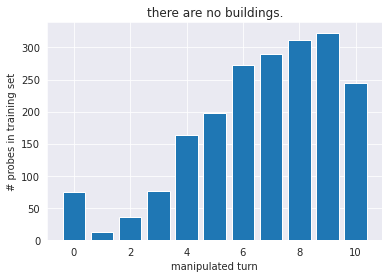

In [66]:
s = 'there are no buildings.'
example = Counter()
for x in turns_shared:
    if x[0] == s:
        example.update([x[1]])

plt.bar(example.keys(), example.values())
plt.xlabel('manipulated turn')
plt.ylabel('# probes in training set')
plt.title(s)
plt.show()

Plot a few examples for the paper:

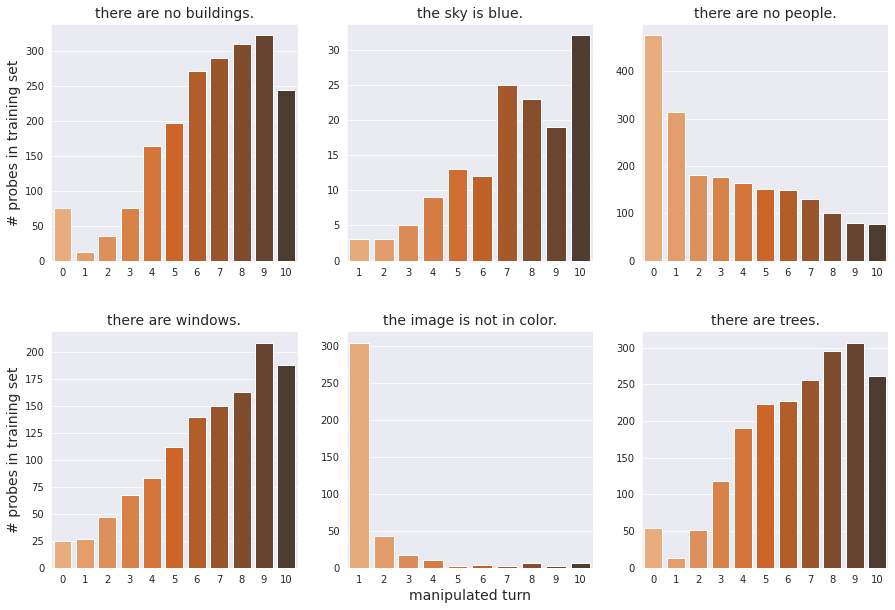

In [67]:
sents = ['there are no buildings.', 'the sky is blue.', 'there are no people.', 'there are windows.',
        'the image is not in color.', 'there are trees.']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

for i, ax in enumerate(axes.flatten()):
    
    s = sents[i]
    example = Counter()
    for x in turns_shared:
        if x[0] == s:
            example.update([x[1]])

    ax = sns.barplot(x=list(example.keys()), y=list(example.values()), palette="Oranges_d", ax=ax)
    if i == 4:
        ax.set_xlabel('manipulated turn', fontsize=14)
    if i == 0 or i == 3:
        ax.set_ylabel('# probes in training set', fontsize=14)
    ax.set_title(s, fontsize=14)

# split = 'train'
#plt.savefig(f'plots/props-skewedPS_{which_probes[split]}.pdf')
plt.show()

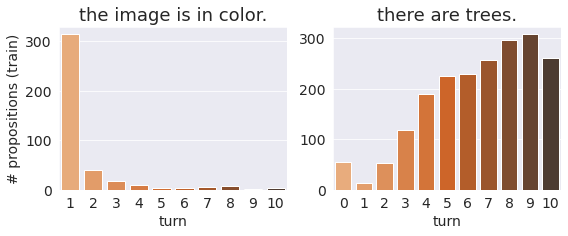

In [68]:
sents = ['the image is in color.', 'there are trees.']
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
# https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

for i, ax in enumerate(axes.flatten()):
    
    s = sents[i]
    example = Counter()
    for x in turns_shared:
        if x[0] == s:
            example.update([x[1]])

    ax = sns.barplot(x=list(example.keys()), y=list(example.values()), palette="Oranges_d", ax=ax)
    ax.set_xlabel('turn', fontsize=14)
    ax.tick_params(labelsize=14)
    if i == 0 or i == 3:
        ax.set_ylabel('# propositions (train)', fontsize=14)
    ax.set_title(s, fontsize=18)

split = 'train'
plt.savefig(f'plots/props-skewedPS_{which_probes[split]}{split}.pdf', bbox_inches="tight")
plt.show()

Some probes have a distribution over manipulated turns that is skewed towards private (or shared). This may be a shorcut for the classifier.

# Examples for the paper

The image used in the paper is from the training data, index 8778.

In [69]:
ID = 8778
split = 'train'
get_vd_dialogue(visdial[split]['data']['dialogs'][ID], split) 

('a small bird sitting on a branch of a tree',
 [('what color is the bird', 'gray'),
  ('is the tree full of leaves', 'no'),
  ('is it daylight out', 'day'),
  ('is it sunny', 'yes'),
  ('is the birds mouth open', 'no'),
  ('do you see any buildings', 'no'),
  ('is this a close up photo', 'yes'),
  ('is the bird tiny', 'yes'),
  ('what type of bird is this', 'wren'),
  ('is there anything else in the photo', 'only the tree')])

In [70]:
caption, turns = get_vd_dialogue(datasets[split][ID], split, add_punct=True)
dialogue = [('', caption)] + turns

probes = [[] for n in range(11)]
for p in propositions[split][str(ID)].values():
    turn = int(p['turn_shared'])
    probes[turn].append(p['proposition'])

for n in range(11):
    print(f'{n} {dialogue[n][0]} {dialogue[n][1]}')
    if probes[n]:
        for i in range(0, len(probes[n]), 2):
            print(f'\t{probes[n][i]}\n\t{probes[n][i+1]}')
    else:
        print('    --')

0  a small bird sitting on a branch of a tree.
    --
1 what color is the bird? gray.
    --
2 is the tree full of leaves? no.
    --
3 is it daylight out? day.
    --
4 is it sunny? yes.
    --
5 is the birds mouth open? no.
    --
6 do you see any buildings? no.
	one can see buildings.
	one cannot see any buildings.
7 is this a close up photo? yes.
    --
8 is the bird tiny? yes.
    --
9 what type of bird is this? wren.
    --
10 is there anything else in the photo? only the tree.
    --


In [71]:
labels = {(1, 1): 0,  # 'a thinks true and shared'
          (0, 1): 1,  # 'a thinks false and shared'
          (1, 0): 2,  # 'a thinks true and private'
          (0, 0): 3,  # 'a thinks false and private'
         }

label_names = {0: 'a thinks true \n shared',   1: 'a thinks false \n shared',
               2: 'a thinks true \n private',  3: 'a thinks false \n private'}

In [72]:
def get_vd_scoreboard(ID, split):
    
    scorekeeping = np.zeros([11, len(propositions[split][str(ID)])])
    
    caption = datasets[split][ID]['caption'] + '.'
    turns = []
    for qa in datasets[split][ID]['dialog']:
        q = visdial[split]['data']['questions'][qa['question']] + '?'
        a = visdial[split]['data']['answers'][qa['answer']] + '.'
        turns.append((q, a))
    turns = [('', caption)] + turns

    probes = [[] for n in range(11)]
    for p, prop in enumerate(propositions[split][str(ID)].values()):
        turn = int(prop['turn_shared'])
        tf = prop['a_thinks_true']
        probes[turn].append(prop['proposition'])
        scorekeeping[:, p] = np.array([[labels[(tf, 0)] if x < turn else labels[(tf, 1)] 
                                       for x in range(11)]])
        
    return turns, probes, scorekeeping

### Examples of generated propositions on full dialogues for the appendix

For this we'll use the original-downsampled training set.

In [73]:
split = 'train'

In [74]:
with open(f'{DIR}downsampled-propositions_{split}.json', 'r') as data:
    props = json.load(data)
    downsampled_train = props['dialogues']

In [75]:
for d, dialogue in enumerate(visdial[split]['data']['dialogs']):
    if dialogue['image_id'] == 318405: #121622, 16677, 364032, 141086, 84859, 283921, 469898, 391229
        ID = d
        break

In [76]:
caption, turns = get_vd_dialogue(visdial[split]['data']['dialogs'][ID], split)
dialogue = [('', caption)] + turns

probes = [[] for n in range(11)]
for p in downsampled_train[str(ID)].values():
    turn = int(p['turn_shared'])
    probes[turn].append(p['proposition'])

for n in range(11):
    print(f'{dialogue[n][0]}? {dialogue[n][1]}.')
    if probes[n]:
        for i in range(0, len(probes[n]), 2):
            print(f'    {probes[n][i]}\n    {probes[n][i+1]}')
    else:
        print('    none')

? a serving of dessert that includes various berries.
    none
does this food look appetizing? no.
    none
is veggies on dish? nope just fruit.
    none
do you see apples? no apples.
    one cannot see any apples.
    one can see apples.
do you see grapes? no gapes at all.
    one cannot see any grapes.
    one can see grapes.
what is main fruit on dish? strawberries and blueberries.
    none
do strawberries still have green on them? yes it does.
    none
are blueberries large? no small and smashed.
    the blueberries are not large.
    the blueberries are large.
can you tell what color plate is? it is white bowl.
    none
can you tell color of table? no,.
    none
do you see people? no.
    one cannot see any people.
    one can see people.


### Example for the scorekeeping matrix:

For this we use the original dataset.

In [77]:
with open(f'{DIR}original/propositions_{split}.json', 'r') as data:
    props = json.load(data)
    original_train = props['dialogues']

In [78]:
# rewrite from above, original_train is hardcoded!
def get_vd_original_scoreboard(ID, split):
    
    scorekeeping = np.zeros([11, len(original_train[str(ID)])])
    
    caption = datasets[split][ID]['caption'] + '.'
    turns = []
    for qa in datasets[split][ID]['dialog']:
        q = visdial[split]['data']['questions'][qa['question']] + '?'
        a = visdial[split]['data']['answers'][qa['answer']] + '.'
        turns.append((q, a))
    turns = [('', caption)] + turns

    probes = [[] for n in range(11)]
    for p, prop in enumerate(original_train[str(ID)].values()):
        turn = int(prop['turn_shared'])
        tf = prop['a_thinks_true']
        probes[turn].append(prop['proposition'])
        scorekeeping[:, p] = np.array([[labels[(tf, 0)] if x < turn else labels[(tf, 1)] 
                                       for x in range(11)]])
        
    return turns, probes, scorekeeping

In [79]:
for d, dialogue in enumerate(visdial[split]['data']['dialogs']):
    if dialogue['image_id'] == 176904: # 208589, 478148, 209419, 407235, 3926
        ID = d
        break

In [80]:
turns, probes, scoreboard = get_vd_original_scoreboard(ID, split)

for n in range(11):
    print(f'{turns[n][0]} {turns[n][1]}')
    if probes[n]:
        for i in range(0, len(probes[n]), 2):
            print(f'    {probes[n][i]}\n    {probes[n][i+1]}')
    else:
        print('    none')

 a small bird sitting on a branch of a tree.
    one can see a small bird.
    one cannot see a small bird.
    there is a branch.
    there is no branch.
    there is a tree.
    there is no tree.
what color is the bird? gray.
    the bird is gray.
    the bird is not gray.
is the tree full of leaves? no.
    none
is it daylight out? day.
    it is daytime.
    it is not daytime.
is it sunny? yes.
    it is sunny.
    it is not sunny.
is the birds mouth open? no.
    none
do you see any buildings? no.
    one cannot see any buildings.
    one can see buildings.
is this a close up photo? yes.
    none
is the bird tiny? yes.
    the bird is tiny.
    the bird is not tiny.
what type of bird is this? wren.
    the bird is wren.
    the bird is not wren.
is there anything else in the photo? only the tree.
    none


In [81]:
columns = [q + ' ' + a for (q, a) in turns]
index = [x for p in probes for x in p]
df = pd.DataFrame(data=scoreboard.T, columns=columns, index=index)

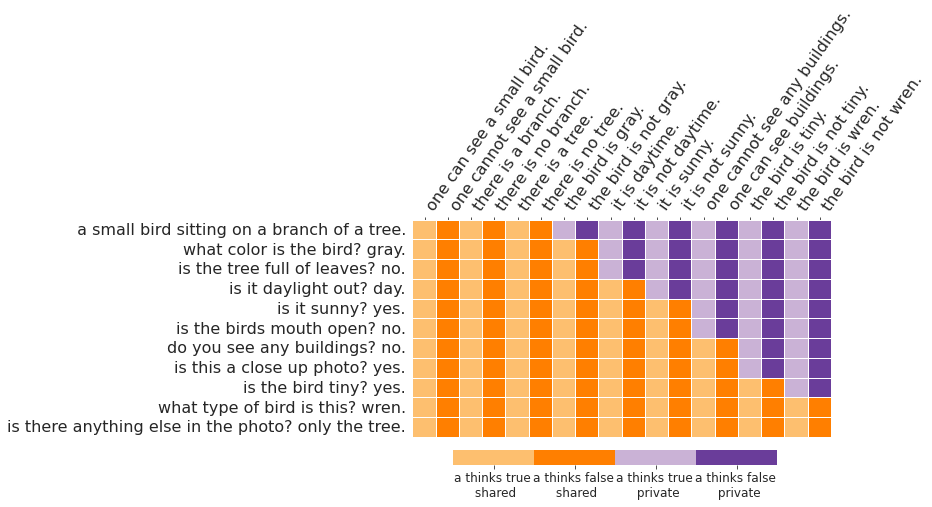

In [83]:
fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 4))
cbar_ax = fig.add_axes([.2, .03, .6, .05])
custom_palette = sns.color_palette("Paired")[6:6+n]
vmap = {k: " and\n".join(label_names[k].split(' and ')) for k in range(4)}
n = len(vmap)

ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_yticklabels(labels=ax1.get_yticklabels(), va='center', size=16)
matrix = sns.heatmap(df.transpose(), annot=False, cmap=custom_palette, ax=ax1, linewidths=0.1, cbar_ax=cbar_ax, cbar_kws={'orientation': 'horizontal'})
matrix.set_xticklabels(matrix.get_xticklabels(), rotation=55, ha='left', size=16)

# https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot
colorbar = ax1.collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(list(vmap.values()))
colorbar.ax.tick_params(labelsize=12)

plt.savefig('plots/orig-scoreboard-example.pdf', bbox_inches="tight")
plt.show()